In [1]:
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import torch
from tqdm import tqdm

from rocketshp import config

2025-01-13 12:23:03.170 | INFO     | rocketshp.config:<module>:13 - PROJ_ROOT path is: /mnt/home/ssledzieski/Projects/rocketshp


/home/ssledzieski/miniforge3/envs/torch/lib/python3.11/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
data_dir = config.RAW_DATA_DIR / "atlas"
meta_dir = config.RAW_DATA_DIR / "atlas_meta"

import glob

file_list = glob.glob(f"{data_dir}/*/*protein.zip")
protein_list = ["_".join(f.split("/")[-1].split("_")[:2]) for f in file_list]

In [62]:
protein_list[:10]

['1lri_A',
 '1l9l_A',
 '1lc3_A',
 '1l5o_A',
 '1lfp_A',
 '1l2p_A',
 '1l2w_I',
 '1lwd_B',
 '1lj5_A',
 '1lr0_A']

In [4]:
def slice_trajectory(traj, start=0, end=None, step=1):
    if end is not None:
        return traj[start:end:step]
    else:
        return traj[start::step]

def slice_trajectory_tensor(xyz, start, end, step=1):
    return xyz[start:end:step, :, :]


In [64]:
protein_list[:10]

['1lri_A',
 '1l9l_A',
 '1lc3_A',
 '1l5o_A',
 '1lfp_A',
 '1l2p_A',
 '1l2w_I',
 '1lwd_B',
 '1lj5_A',
 '1lr0_A']

In [69]:
from rocketshp.esm3 import _get_structure_vae, _get_tokenizers, struct_tokenize_frame

stride = 10

device = torch.device("cuda:0")
encoder = _get_structure_vae()[0]
tokenizer = _get_tokenizers().structure
encoder = encoder.to(device)

all_toks = {}

for pil in tqdm(protein_list[:10]):

    traj = md.load_xtc(data_dir / pil[:2] / f"{pil}_prod_R1_fit.xtc", top=data_dir / pil[:2] / f"{pil}.pdb")
    traj.center_coordinates()
    traj = traj.superpose(traj, 0)

    struct_toks = []
    with torch.inference_mode():
        for f in tqdm(slice_trajectory(traj, 0, None, stride), total = len(traj) // stride):
            struct_toks.append(
                struct_tokenize_frame(f, encoder, tokenizer, device)
            )
        struct_toks = torch.stack(struct_toks)
    all_toks[pil] = struct_toks.cpu().numpy()

  0%|          | 0/10 [00:00<?, ?it/s]/home/ssledzieski/miniforge3/envs/torch/lib/python3.11/site-packages/esm/models/vqvae.py:289: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=False):  # type: ignore
1001it [00:13, 76.50it/s]                         
1001it [00:10, 91.07it/s]                         
1001it [00:34, 29.08it/s]                         
1001it [00:38, 25.96it/s]                         
1001it [00:29, 33.42it/s]                         
1001it [00:09, 109.06it/s]22<02:43, 32.68s/it]
1001it [00:09, 101.67it/s]                        
1001it [00:46, 21.39it/s]                         
1001it [00:44, 22.63it/s]:15<01:13, 36.70s/it]
1001it [00:16, 59.00it/s]                         
100%|██████████| 10/10 [05:23<00:00, 32.32s/it]


In [42]:
def normalize_sum(x):
    return x / x.sum()

In [50]:
normalize_sum(torch.bincount(struct_toks[:,0].cpu(),minlength=4096)).max()

tensor(0.6354)

In [ ]:
plt.imshow(normalize_sum(torch.from_numpy(all_toks[protein_list[4]].T)))
plt.show()

NameError: name 'plt' is not defined

In [99]:
ns[ns > 0.005]

tensor([0.0480, 0.0689, 0.0130, 0.0460, 0.0490, 0.2248, 0.0120, 0.0070, 0.0130,
        0.0170, 0.0250, 0.1838, 0.0749, 0.0120, 0.0200, 0.1329, 0.0310])

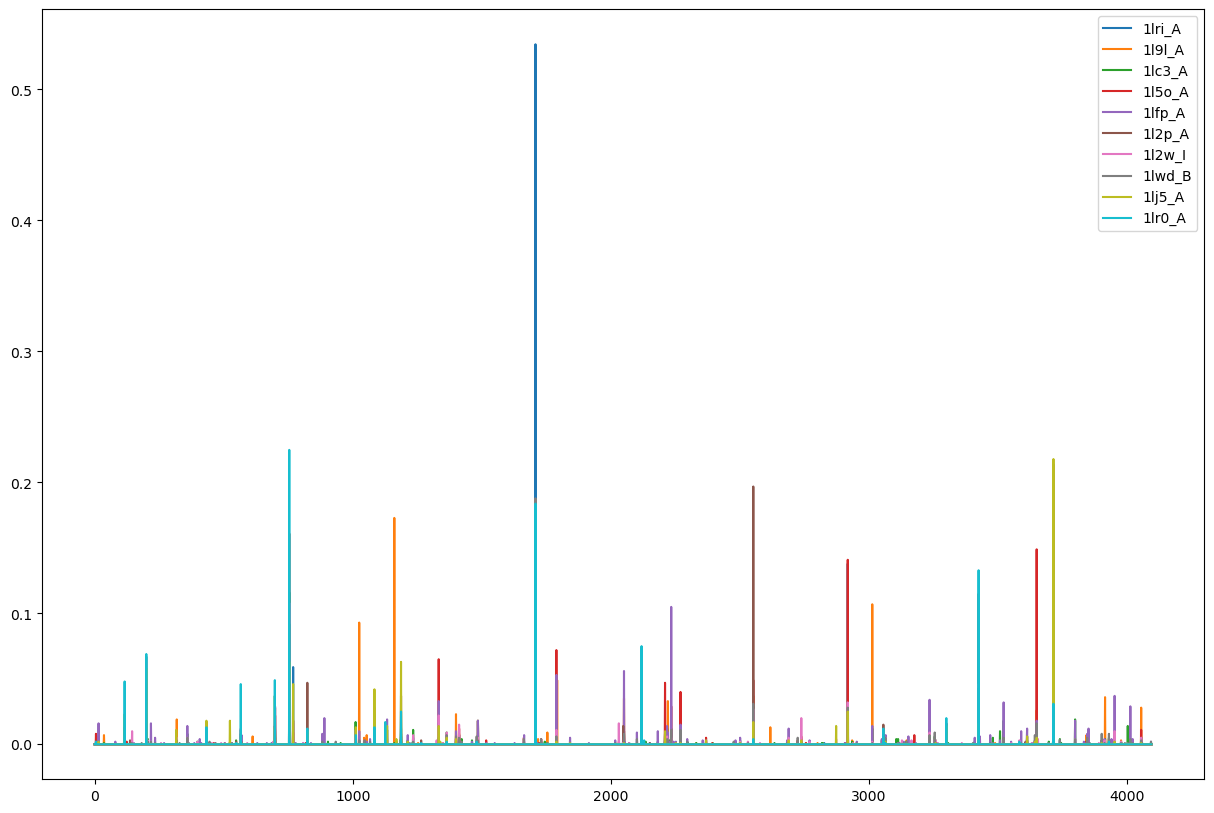

In [93]:
fig,ax = plt.subplots(1,1,figsize=(15,10))

for k,v in all_toks.items():
    ns = normalize_sum(torch.bincount(torch.from_numpy(v)[:,0],minlength=4096))

    plt.plot(np.arange(4096),ns, label=k)
plt.legend()
plt.show()